In [ ]:
# default_exp modeling.question_answering

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import ast

from blurr.data.all import *
from blurr.modeling.core import *

import torch
from transformers import *
from fastai2.text.all import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    """We need to return everything from the model for question/answer tasks"""
    def after_pred(self): self.learn.pred = self.pred

In [ ]:
#export
class HF_QstAndAnsModelWrapper(HF_BaseModelWrapper):
    """A custom model wrapper for question answer models since we need all the outputs (not just the first)"""
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('attention_mask', x[1])): model_kwargs['attention_mask'] = x[1]
        if (self._include_arg('token_type_ids', x[2])): model_kwargs['token_type_ids'] = x[2]
        if (self._include_arg('cls_index', x[3])): model_kwargs['cls_index'] = x[3]
        if (self._include_arg('p_mask', x[4])): model_kwargs['p_mask'] = x[4]
        
        return self.hf_model(**model_kwargs)

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
path = Path('./')
squad_df = pd.read_csv(path/'squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_tokenizer_cls = BertTokenizer
hf_model_cls = HF_MODELS.BertForQuestionAnswering

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               hf_tokenizer_cls,
                                                                               hf_model_cls)


# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

In [ ]:
def pre_process_squad(row):
    context, qst, ans = row['context'], row['question_text'], row['answer_text']
    
    add_prefix_space = hf_arch in ['gpt2', 'roberta']
    
    if(hf_tokenizer.padding_side == 'right'):
        tok_input = hf_tokenizer.convert_ids_to_tokens(hf_tokenizer.encode(qst, context, 
                                                                           add_prefix_space=add_prefix_space))
    else:
        tok_input = hf_tokenizer.convert_ids_to_tokens(hf_tokenizer.encode(context, qst, 
                                                                           add_prefix_space=add_prefix_space))
                                                                       
    tok_ans = hf_tokenizer.tokenize(str(row['answer_text']), 
                                    add_special_tokens=False, 
                                    add_prefix_space=add_prefix_space)
    
    start_idx, end_idx = 0,0
    for idx, tok in enumerate(tok_input):
        try:
            if (tok == tok_ans[0] and tok_input[idx:idx + len(tok_ans)] == tok_ans): 
                start_idx, end_idx = idx, idx + len(tok_ans)
                break
        except: pass
            
    row['tokenized_input'] = tok_input
    row['tokenized_input_len'] = len(tok_input)
    row['tok_answer_start'] = start_idx
    row['tok_answer_end'] = end_idx
    
    return row

In [ ]:
squad_df = squad_df.apply(pre_process_squad, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (16 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
max_seq_len= 512

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
#hide
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33,"[[CLS], what, does, f, ##d, ##ny, stand, for, ?, [SEP], the, new, york, city, fire, department, (, f, ##d, ##ny, ), ,, provides, fire, protection, ,, technical, rescue, ,, primary, response, to, biological, ,, chemical, ,, and, radioactive, hazards, ,, and, emergency, medical, services, for, the, five, boroughs, of, new, york, city, ., the, new, york, city, fire, department, is, the, largest, municipal, fire, department, in, the, united, states, and, the, second, largest, in, the, world, after, the, tokyo, fire, department, ., the, f, ##d, ##ny, employs, approximately, 11, ,, 08, ##0, unif...",123,11,16
5,Communications_in_Somalia,"The Somali Postal Service (Somali Post) is the national postal service of the Federal Government of Somalia. It is part of the Ministry of Information, Posts and Telecommunication.",56e1b959cd28a01900c67ad1,What is the name of the National postal service of Somalia?,False,Somali Post,4,15,"[[CLS], what, is, the, name, of, the, national, postal, service, of, somalia, ?, [SEP], the, somali, postal, service, (, somali, post, ), is, the, national, postal, service, of, the, federal, government, of, somalia, ., it, is, part, of, the, ministry, of, information, ,, posts, and, telecommunication, ., [SEP]]",48,19,21


In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'
hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, max_seq_len=max_seq_len, truncation_strategy=trunc_strat, 
                                 task=ForQuestionAnsweringTask())

blocks = (
    HF_TextBlock(hf_arch, hf_tokenizer, hf_batch_tfm=hf_batch_tfm), 
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

def get_x(x):
    return (x.question_text, x.context) if (hf_tokenizer.padding_side == 'right') else (x.context, x.question_text)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]

(2, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_
0,"who held parliamentary elections on august 25, 1948? citing the inability of the joint commission to make progress, the u. s. government decided to hold an election under united nations auspices with the aim of creating an independent korea. the soviet authorities and the korean communists refused to co - operate on the grounds it would not be fair, and many south korean politicians also boycotted it. a general election was held in the south on 10 may 1948. it was marred by terrorism and sabotage resulting in 600 deaths. north korea held parliamentary elections three months later on 25 august.",103,105
1,"when did the art deco area of miami boom some sections of the state feature architectural styles including spanish revival, florida vernacular, and mediterranean revival style. it has the largest collection of art deco and streamline moderne buildings in both the united states and the entire world, most of which are located in the miami metropolitan area, especially miami beach's art deco district, constructed as the city was becoming a resort destination. a unique architectural design found only in florida is the post - world war ii miami modern, which can be seen in areas such as miami's mimo historic district.",67,84


In [ ]:
model = HF_QstAndAnsModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
x, y_start, y_end = dls.one_batch()
preds = learn.model(x)
len(preds),preds[0].shape

(2, torch.Size([4, 128]))

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=9.12010818865383e-07)

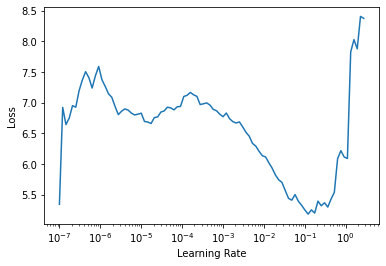

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.384950,3.177536,00:04
1,2.903434,2.540561,00:04
2,2.390975,2.490370,00:04


In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, skip_special_tokens=True, max_n=2)

,text,category,category_,target1,target2
0,"in 2011, what was the estimated population of southampton inside city limits? southampton had an estimated 236, 900 people living within the city boundary in 2011. there is a sizeable polish population in the city, with estimates as high as 20, 000.",20,23,20,23
1,"who was the leader of the kuomintang ( kmt ; nationalist party )? in 1927, the kuomintang ( kmt ; nationalist party ) under generalissimo chiang kai - shek again established nanjing as the capital of the republic of china, and this became internationally recognized once kmt forces took beijing in 1928. the following decade is known as the nanking decade.",36,44,36,43


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question_text': 'What did George Lucas make?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.predict(inf_df.iloc[0])

(('11', '12'),
 tensor([11]),
 tensor([[9.8583e-05, 6.9642e-06, 7.1893e-07, 1.3669e-06, 5.6652e-07, 1.1096e-06,
          1.1558e-07, 9.8593e-05, 5.1735e-04, 4.0655e-05, 1.4490e-03, 9.9693e-01,
          1.1657e-04, 1.8335e-05, 3.2918e-05, 9.8655e-05, 2.4656e-04, 8.8927e-05,
          3.5984e-06, 3.7526e-05, 6.4287e-06, 9.8576e-05, 9.8602e-05, 9.0556e-08,
          9.6937e-08, 9.2919e-08, 9.3745e-08, 9.3721e-08, 9.6599e-08, 9.6850e-08,
          9.2236e-08, 9.4708e-08, 9.5769e-08, 9.4555e-08, 8.9345e-08, 8.7661e-08,
          9.0842e-08, 9.1153e-08, 8.7228e-08, 8.7961e-08, 8.9612e-08, 9.1987e-08,
          9.3279e-08, 9.0973e-08, 9.4628e-08, 9.4065e-08, 9.4577e-08, 9.3619e-08,
          9.3516e-08, 9.4542e-08, 9.6600e-08, 9.5639e-08, 9.5440e-08, 9.7230e-08,
          1.0018e-07, 9.9591e-08, 9.7887e-08, 9.5673e-08, 9.7419e-08, 1.0072e-07,
          9.9530e-08, 9.5778e-08, 9.4315e-08, 9.5967e-08, 1.0063e-07, 9.5456e-08,
          9.2705e-08, 9.5656e-08, 9.5962e-08, 9.8399e-08, 9.5258e-08

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'question_text': 'When was Star Wars made?',
    'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp, probs, _, preds = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp[0].tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,time
0,1.971706,2.260911,00:14
1,1.812833,2.116430,00:14
2,1.507805,2.098108,00:14


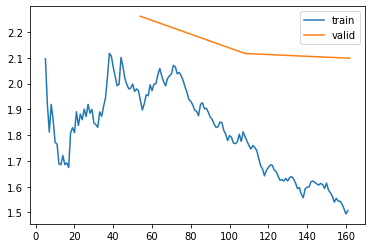

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_,target1,target2
0,"in 2011, what was the estimated population of southampton inside city limits? southampton had an estimated 236, 900 people living within the city boundary in 2011. there is a sizeable polish population in the city, with estimates as high as 20, 000.",20,23,20,23
1,"in what century was the process of using hops to produce beer introduced to england? traditional english ale was made solely from fermented malt. the practice of adding hops to produce beer was introduced from the netherlands in the early 15th century. alehouses would each brew their own distinctive ale, but independent breweries began to appear in the late 17th century. by the end of the century almost all beer was brewed by commercial breweries.",49,50,49,51


In [ ]:
learn.predict(inf_df.iloc[0])

(('14', '15'),
 tensor([14]),
 tensor([[2.1051e-04, 1.4965e-05, 3.5126e-06, 2.0267e-06, 1.1221e-06, 5.5259e-06,
          7.9548e-07, 2.1052e-04, 1.0065e-04, 1.7669e-05, 9.2929e-05, 1.9235e-04,
          5.6468e-06, 9.4419e-03, 9.8923e-01, 8.7749e-06, 5.8271e-06, 3.3213e-06,
          1.1026e-06, 2.6803e-06, 3.2076e-06, 2.1046e-04, 2.1020e-04, 2.5764e-07,
          2.7864e-07, 2.6739e-07, 2.6776e-07, 2.6173e-07, 2.6783e-07, 2.5803e-07,
          2.6170e-07, 2.6033e-07, 2.7378e-07, 2.7268e-07, 2.5765e-07, 2.5895e-07,
          2.5874e-07, 2.5695e-07, 2.5454e-07, 2.5642e-07, 2.5216e-07, 2.5463e-07,
          2.6061e-07, 2.5975e-07, 2.6043e-07, 2.6108e-07, 2.5774e-07, 2.6245e-07,
          2.6254e-07, 2.6159e-07, 2.7621e-07, 2.6878e-07, 2.6747e-07, 2.6991e-07,
          2.6985e-07, 2.7487e-07, 2.7192e-07, 2.6955e-07, 2.6849e-07, 2.8719e-07,
          2.8630e-07, 2.7368e-07, 2.7182e-07, 2.7081e-07, 2.7546e-07, 2.6864e-07,
          2.6878e-07, 2.6639e-07, 2.6746e-07, 2.8771e-07, 2.7056e-07

In [ ]:
preds, pred_classes, probs = learn.predict(inf_df.iloc[0])
preds

('14', '15')

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0]):int(preds[1])]

['1977']

And what about inference?

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'question_text': 'Who created Star Wars?', 
     'context': 'George Lucas created Star Wars in 1977. He directed and produced it.'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])

(('7', '9'),
 tensor([7]),
 tensor([[6.8899e-05, 1.8356e-06, 6.2198e-07, 2.0067e-06, 4.0033e-07, 2.2773e-07,
          6.8908e-05, 9.9879e-01, 8.1258e-04, 4.4955e-06, 3.7813e-05, 9.2774e-07,
          7.8631e-06, 3.2751e-05, 1.1354e-06, 2.1856e-05, 1.4235e-06, 3.8101e-07,
          9.3907e-07, 5.9589e-07, 6.8900e-05, 6.8089e-05, 9.9725e-08, 1.1202e-07,
          1.0450e-07, 1.0334e-07, 1.0523e-07, 1.0467e-07, 1.0587e-07, 1.0087e-07,
          1.0148e-07, 1.1506e-07, 1.1065e-07, 1.0089e-07, 9.8886e-08, 1.0081e-07,
          1.0005e-07, 9.9269e-08, 1.0244e-07, 1.0104e-07, 1.0189e-07, 1.0285e-07,
          1.0396e-07, 1.0307e-07, 1.0513e-07, 1.0547e-07, 1.0449e-07, 1.0629e-07,
          1.0601e-07, 1.1145e-07, 1.1330e-07, 1.0934e-07, 1.0688e-07, 1.0758e-07,
          1.0916e-07, 1.0858e-07, 1.0682e-07, 1.0579e-07, 1.1652e-07, 1.1695e-07,
          1.0702e-07, 1.0608e-07, 1.0561e-07, 1.0611e-07, 1.0762e-07, 1.0516e-07,
          1.0549e-07, 1.0575e-07, 1.0948e-07, 1.1019e-07, 1.0639e-07, 1

In [ ]:
inp_ids = hf_tokenizer.encode('Who created Star Wars?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[7:9]

['george', 'lucas']

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01a_data-language-modeling.ipynb.
Converted 01c_data-question-answering.ipynb.
Converted 01d_data-token-classification.ipynb.
Converted 02_modeling-core.ipynb.
Converted 02a_modeling-language-modeling.ipynb.
Converted 02c_modeling-question-answering.ipynb.
Converted 02d_modeling-token-classification.ipynb.
Converted index.ipynb.
